In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.layers import concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc

C:\Users\vibhanshuv\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
% cd "C:\Users\vibhanshuv\Downloads\Case Study 1\aclImdb"

C:\Users\vibhanshuv\Downloads\Case Study 1\aclImdb


In [5]:
import pandas as pd
import csv

words = pd.read_table('glove.6B.100d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE,na_values=None, keep_default_na=False)

In [6]:
def vec(w):
  return words.loc[w].as_matrix()

### Printing vector of a word

In [7]:
vec('yes')

array([-0.050131 ,  0.66356  ,  0.84315  , -0.75295  , -0.42848  ,
        0.161    , -0.03673  ,  0.074777 ,  0.35251  , -0.28556  ,
        0.20641  , -0.043102 , -0.37978  , -0.052587 ,  0.29311  ,
       -0.45879  , -0.47363  ,  0.20305  , -0.45185  ,  0.81729  ,
        0.16955  ,  0.55388  , -0.56667  , -0.6804   ,  0.10162  ,
        0.43306  , -0.041035 , -0.33196  ,  0.39855  , -0.42924  ,
        0.16037  ,  0.67055  ,  0.56775  , -0.036795 ,  0.36762  ,
        0.20562  ,  0.48372  , -0.0023657,  0.30896  , -0.55975  ,
       -0.093893 ,  0.045387 ,  0.13003  , -0.47783  , -0.62755  ,
       -0.92217  ,  0.034079 , -0.23645  , -0.7976   , -1.0137   ,
        0.11884  ,  0.051346 ,  0.18324  ,  0.44278  , -0.47314  ,
       -1.5531   ,  0.56763  ,  0.63797  ,  0.64317  ,  0.21479  ,
       -0.20058  ,  0.28966  , -0.66742  , -0.7743   ,  0.70983  ,
        0.25972  ,  0.4592   ,  0.27178  , -0.57331  , -0.072424 ,
        0.36847  ,  0.46355  , -0.018428 , -0.41952  ,  0.1341

In [8]:
train_df=pd.read_csv('pre_train.csv',sep=",")
test_df=pd.read_csv('pre_test.csv',sep=",")

In [9]:
train_df=train_df.reindex(np.random.permutation(train_df.index))
test_df=test_df.reindex(np.random.permutation(test_df.index))

In [10]:
train_df.head()

,Unnamed: 0,description,sentiment,words,words_sent
13781,13781,"virile, but naive, big joe buck leaves his hom...",1,"['virile', 'naive', 'big', 'joe', 'buck', 'lea...",virile naive big joe buck leaf home big spring...
3898,3898,"for the life of me, i cannot get why they woul...",0,"['life', 'not', 'get', 'would', 'want', 'make'...",life not get would want make movie `` jerry sp...
23071,23071,the name of this film alone made me want to se...,1,"['name', 'film', 'alone', 'made', 'want', 'see...",name film alone made want see all taped film e...
6273,6273,"one of my sisters friends lent me this game, a...",0,"['one', 'sister', 'friend', 'lent', 'game', 't...",one sister friend lent game too damn hard carr...
20720,20720,i've just purchased the restored version of a ...,1,"[""'ve"", 'purchased', 'restored', 'version', 'f...",'ve purchased restored version film remember m...


In [11]:
Y_train=train_df['sentiment']
Y_test=test_df['sentiment']

In [12]:
X_train=train_df['words_sent']
X_test=test_df['words_sent']

In [13]:
embed_size=0

In [14]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [15]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [16]:
def loadEmbeddingMatrix():
    EMBEDDING_FILE='glove.6B.100d.txt'
    embed_size = 100
    embeddings_index = dict()
    #Transfer the embedding weights into a dictionary by iterating through every line of the file.
    f = open(EMBEDDING_FILE,encoding="utf8")
    for line in f:
        #split up line into an indexed array
        values = line.split()
        #first index is word
        word = values[0]
        #store the rest of the values in the array as a new array
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs #50 dimensions
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    gc.collect()
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    nb_words = len(tokenizer.word_index)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()
    #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
    #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
        i-=1
        #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        #and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
    #finally, return the embedding matrix
    return embedding_matrix

In [17]:
embedding_matrix = loadEmbeddingMatrix()

Loaded 400000 word vectors.
total embedded: 55393 common words


In [81]:
embedding_matrix.shape

(126071, 100)

In [110]:
inp = Input(shape=(maxlen, ))

In [37]:
from keras.layers import SpatialDropout1D, BatchNormalization
inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
embedded_sequences = SpatialDropout1D(0.4)(x)
x = LSTM(100, return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(1, activation='sigmoid')(x)

In [38]:
model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='acc', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint('lstm',monitor='acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='acc', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 200, 100)          7416600   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total para

In [41]:
history=model.fit(X_t,Y_train,batch_size=16,epochs=500,shuffle=True,verbose=2,validation_split=0.2,callbacks=[ model_checkpoint,reduce_lr,early_stopping])

Train on 20000 samples, validate on 5000 samples
Epoch 1/500
 - 75s - loss: 0.6764 - acc: 0.5769 - val_loss: 0.7510 - val_acc: 0.5260

Epoch 00001: acc improved from 0.53715 to 0.57695, saving model to lstm
Epoch 2/500
 - 81s - loss: 0.6271 - acc: 0.6411 - val_loss: 0.5553 - val_acc: 0.7170

Epoch 00002: acc improved from 0.57695 to 0.64115, saving model to lstm
Epoch 3/500
 - 80s - loss: 0.5761 - acc: 0.6906 - val_loss: 0.5248 - val_acc: 0.7360

Epoch 00003: acc improved from 0.64115 to 0.69060, saving model to lstm
Epoch 4/500
 - 78s - loss: 0.5447 - acc: 0.7191 - val_loss: 0.4795 - val_acc: 0.7620

Epoch 00004: acc improved from 0.69060 to 0.71915, saving model to lstm
Epoch 5/500
 - 74s - loss: 0.5256 - acc: 0.7337 - val_loss: 0.4924 - val_acc: 0.7518

Epoch 00005: acc improved from 0.71915 to 0.73370, saving model to lstm
Epoch 6/500
 - 71s - loss: 0.5118 - acc: 0.7468 - val_loss: 0.4519 - val_acc: 0.7816

Epoch 00006: acc improved from 0.73370 to 0.74675, saving model to lstm
Epo


Epoch 00055: acc did not improve from 0.86575
Epoch 56/500
 - 72s - loss: 0.3238 - acc: 0.8618 - val_loss: 0.3558 - val_acc: 0.8484

Epoch 00056: acc did not improve from 0.86575
Epoch 57/500
 - 71s - loss: 0.3199 - acc: 0.8632 - val_loss: 0.3650 - val_acc: 0.8518

Epoch 00057: acc did not improve from 0.86575
Epoch 58/500
 - 72s - loss: 0.3190 - acc: 0.8622 - val_loss: 0.3567 - val_acc: 0.8502

Epoch 00058: acc did not improve from 0.86575

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 59/500
 - 72s - loss: 0.3072 - acc: 0.8690 - val_loss: 0.3594 - val_acc: 0.8530

Epoch 00059: acc improved from 0.86575 to 0.86900, saving model to lstm
Epoch 60/500
 - 73s - loss: 0.3049 - acc: 0.8715 - val_loss: 0.3520 - val_acc: 0.8528

Epoch 00060: acc improved from 0.86900 to 0.87145, saving model to lstm
Epoch 61/500
 - 73s - loss: 0.3029 - acc: 0.8734 - val_loss: 0.3557 - val_acc: 0.8468

Epoch 00061: acc improved from 0.87145 to 0.87340, saving model to l

 - 71s - loss: 0.2489 - acc: 0.8973 - val_loss: 0.3756 - val_acc: 0.8576

Epoch 00111: acc did not improve from 0.89915
Epoch 112/500
 - 71s - loss: 0.2518 - acc: 0.8982 - val_loss: 0.3770 - val_acc: 0.8572

Epoch 00112: acc did not improve from 0.89915
Epoch 113/500
 - 72s - loss: 0.2485 - acc: 0.9006 - val_loss: 0.3801 - val_acc: 0.8582

Epoch 00113: acc improved from 0.89915 to 0.90055, saving model to lstm
Epoch 114/500
 - 71s - loss: 0.2530 - acc: 0.8985 - val_loss: 0.3760 - val_acc: 0.8588

Epoch 00114: acc did not improve from 0.90055
Epoch 115/500
 - 71s - loss: 0.2483 - acc: 0.9001 - val_loss: 0.3771 - val_acc: 0.8574

Epoch 00115: acc did not improve from 0.90055
Epoch 116/500
 - 71s - loss: 0.2457 - acc: 0.9021 - val_loss: 0.3792 - val_acc: 0.8562

Epoch 00116: acc improved from 0.90055 to 0.90210, saving model to lstm
Epoch 117/500
 - 71s - loss: 0.2492 - acc: 0.8997 - val_loss: 0.3795 - val_acc: 0.8562

Epoch 00117: acc did not improve from 0.90210
Epoch 118/500
 - 75s - l

 - 72s - loss: 0.2388 - acc: 0.9045 - val_loss: 0.3802 - val_acc: 0.8568

Epoch 00171: acc did not improve from 0.90725
Epoch 172/500
 - 72s - loss: 0.2404 - acc: 0.9032 - val_loss: 0.3754 - val_acc: 0.8554

Epoch 00172: acc did not improve from 0.90725
Epoch 173/500
 - 73s - loss: 0.2380 - acc: 0.9068 - val_loss: 0.3779 - val_acc: 0.8554

Epoch 00173: acc did not improve from 0.90725
Epoch 00173: early stopping


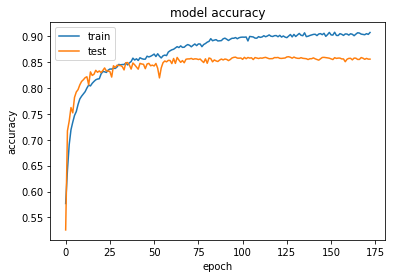

In [42]:
# here we are plotting epochs vs. accuracy 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

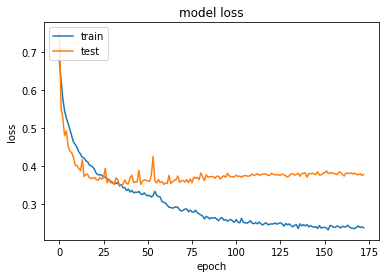

In [43]:
# here we are plotting epochs vs. loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
model.evaluate(X_te, Y_test, batch_size=16, verbose=2)

[0.37861927732229234, 0.85432]